In [1]:
#basemodel on ginsburg batch-size=32
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split

!module load cuda11.0/toolkit cuda11.0/blas cudnn8.0-cuda11.0

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2021-09-22 17:05:30.341453: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Num GPUs Available:  1


2021-09-22 17:07:59.921067: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-22 17:08:00.111269: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-22 17:08:00.455678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2021-09-22 17:08:00.455741: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-22 17:08:04.547689: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-22 17:08:04.547804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-0

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.config.list_physical_devices()

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray,plot_image,preprocess_image

In [4]:
dir_name="../data/data1"
val_dir_name="../data/data2"

chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(dir_name)

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [5]:
chl_images=preprocess_image(chl.Chl.data)
mld_images=preprocess_image(mld.MLD.data)
sss_images=preprocess_image(sss.SSS.data)
sst_images=preprocess_image(sst.SST.data)
xco2_images=preprocess_image(xco2.XCO2.data,xco2=True)
pco2_images=preprocess_image(pco2.pCO2.data,pco2=True)


In [6]:
xco2_images.shape, pco2_images.shape #dimensions

((421, 180, 360, 1), (421, 180, 360, 1))

In [7]:
pco2.pCO2.data.max(), pco2.pCO2.data.min(), pco2.pCO2.data.std() #pco2 information

(831.1136616134033, 0.0, 171.05473677144028)

In [8]:
X = np.stack((chl_images, mld_images, sss_images, sst_images,xco2_images), axis = 1)

In [9]:
INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=pco2_images[0].shape

In [10]:
from functools import partial
from tensorflow import keras
from tensorflow.keras import layers


DefaultConv3D = partial(keras.layers.Conv3D,
                        kernel_size=3,activation='relu', padding="SAME")

base_model = keras.models.Sequential([
    DefaultConv3D(filters=64, input_shape=INPUT_SHAPE),
    DefaultConv3D(filters=64),
    keras.layers.MaxPooling3D(pool_size=3),
    DefaultConv3D(filters=128),
    DefaultConv3D(filters=128),
    keras.layers.Dropout(0.3),
    keras.layers.UpSampling3D(size=(1,3,3)),
    DefaultConv3D(filters=64),
    DefaultConv3D(filters=2),
    DefaultConv3D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])

base_model.summary()

2021-09-22 17:08:45.350140: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-22 17:08:45.368909: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-22 17:08:45.381769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2021-09-22 17:08:45.381850: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-22 17:08:45.381878: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Succ

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 5, 180, 360, 64)   1792      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 180, 360, 64)   110656    
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 1, 60, 120, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 60, 120, 128)   221312    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 60, 120, 128)   442496    
_________________________________________________________________
dropout (Dropout)            (None, 1, 60, 120, 128)   0         
_________________________________________________________________
up_sampling3d (UpSampling3D) (None, 1, 180, 360, 128)  0

In [11]:
base_model.compile(loss="mean_squared_error", optimizer="nadam", metrics=["mean_squared_error"])


In [12]:
model_path="../models/base_model/base_model.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = base_model.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=32,callbacks=callbacks)


2021-09-22 17:09:03.202078: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-22 17:09:03.541811: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz


Epoch 1/100


2021-09-22 17:09:09.208401: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-09-22 17:11:32.069568: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-22 17:11:41.448857: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


14/14 [==============================] - 274s 7s/step - loss: 81759.1492 - mean_squared_error: 81759.1539 - val_loss: 29175.4941 - val_mean_squared_error: 29175.4922
Epoch 2/100
14/14 [==============================] - 37s 2s/step - loss: 30281.6065 - mean_squared_error: 30281.6065 - val_loss: 30411.8574 - val_mean_squared_error: 30411.8574
Epoch 3/100
14/14 [==============================] - 34s 2s/step - loss: 31620.0574 - mean_squared_error: 31620.0578 - val_loss: 25549.2500 - val_mean_squared_error: 25549.2480
Epoch 4/100
14/14 [==============================] - 34s 2s/step - loss: 18044.6449 - mean_squared_error: 18044.6423 - val_loss: 11864.2510 - val_mean_squared_error: 11864.2490
Epoch 5/100
14/14 [==============================] - 34s 2s/step - loss: 9967.1951 - mean_squared_error: 9967.1952 - val_loss: 7628.5503 - val_mean_squared_error: 7628.5513
Epoch 6/100
14/14 [==============================] - 34s 2s/step - loss: 6861.7986 - mean_squared_error: 6861.7988 - val_loss: 596

In [22]:

from tensorflow.keras.models import load_model
base_model = load_model('../models/base_model/base_model.h5')

predicted_image=base_model.predict(X[419:421],verbose=1)

1/1 [==============================] - 0s 123ms/step


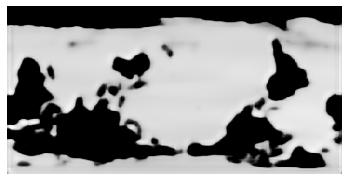

In [23]:
plot_image(np.squeeze(predicted_image[1]))

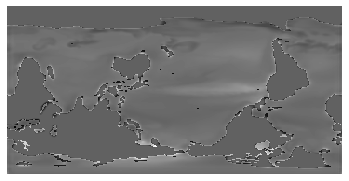

In [24]:
difference=np.squeeze(pco2_images[419:421][1])-np.squeeze(predicted_image[0])
plot_image(difference)

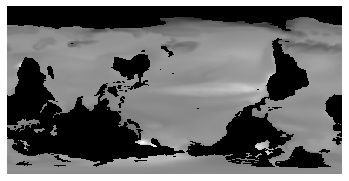

In [25]:
plot_image(np.squeeze(pco2_images[419:421][1]))